In [1]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import scipy.io as sio
import netCDF4 as nc
import glob, os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] =1e12
import cmocean
import xarray as xr
from xgcm import Grid
from gsw import sigma0, rho

In [3]:
%cd /work/eay/MITgcm_data/Experiment33/

#depth = xr.open_dataset('grid.nc')['Depth']
fs= xr.open_dataset('U13.nc')

Temp = xr.open_dataset('Temp13.nc')['Temp'][3,:]
Salt = xr.open_dataset('Salt13.nc')['S'][3,:]
U = xr.open_dataset('U13.nc')['U'][3,:]
V = xr.open_dataset('V13.nc')['V'][3,:]
print('done with variables')

NX = 4000
NY = 4000
NZ = 250

xq = xr.open_dataset('Temp13.nc')['X']
yq = xr.open_dataset('Temp13.nc')['Y']
zl = xr.open_dataset('Temp13.nc')['Z']
Time = xr.open_dataset('Temp13.nc')['T'][3]
print(Time.values/86400,'days')

%cd /work/eay/MITgcm_data/

/work2/eay/MITgcm_data/Experiment33
done with variables
1.3541666666666667 days
/work2/eay/MITgcm_data


In [26]:
%cd /work/eay/MITgcm_data/Experiment33/

#depth = xr.open_dataset('grid.nc')['Depth']
fs= xr.open_dataset('U21.nc')

Temp = xr.open_dataset('Temp21.nc')['Temp'][-1,:]
Salt = xr.open_dataset('Salt21.nc')['S'][-1,:]
U = xr.open_dataset('U21.nc')['U'][-1,:]
V = xr.open_dataset('V21.nc')['V'][-1,:]
print('done with variables')

NX = 4000
NY = 4000
NZ = 250

xq = xr.open_dataset('Temp21.nc')['X']
yq = xr.open_dataset('Temp21.nc')['Y']
zl = xr.open_dataset('Temp21.nc')['Z']
Time = xr.open_dataset('Temp21.nc')['T'][-1]
print(Time.values/86400,'days')

%cd /work/eay/MITgcm_data/

/work2/eay/MITgcm_data/Experiment33
done with variables
2.0416666666666665 days
/work2/eay/MITgcm_data


### Regrid using xgcm so that velocity and tracers are on same points:

In [27]:
print(Temp.shape)
print(Salt.shape)
print(U.shape)
print(V.shape)

grid= Grid(fs, coords={'X': {'center': 'X', 'outer': 'Xp1'}, #This tells the grid where xh, xq, yh, and yq are defined.
                       'Y': {'center': 'Y', 'outer': 'Yp1'}});

U = grid.interp(U,axis='X')#.fillna(0.); 
V = grid.interp(V,axis='Y')#.fillna(0.); 

print(U.shape,V.shape)


(250, 4000, 4000)
(250, 4000, 4000)
(250, 4000, 4001)
(250, 4001, 4000)
(250, 4000, 4000) (250, 4000, 4000)


In [32]:
lim1 = 1333; lim2 =3000; lim3 = 667; lim4 = 2467;

#lim1 = 1133; lim2 =2000; lim3 = 333; lim4 = 867;

Density = rho(Salt[:,lim3:lim4,lim1:lim2],Temp[:,lim3:lim4,lim1:lim2],0)
Usmall = U[:,lim3:lim4,lim1:lim2];
Vsmall = V[:,lim3:lim4,lim1:lim2]
print(Density.shape,Usmall.shape)
print(Density)

(250, 1800, 1667) (250, 1800, 1667)
<xarray.DataArray 'S' (Z: 250, Y: 1800, X: 1667)>
array([[[1011.54966471, 1011.54715247, 1011.54443595, ...,
         1025.08613951, 1025.08613951, 1025.08613951],
        [1011.55681316, 1011.55442551, 1011.55182779, ...,
         1025.08613951, 1025.08613951, 1025.08613951],
        [1011.56390944, 1011.56164205, 1011.55917037, ...,
         1025.08613951, 1025.08613951, 1025.08613951],
        ...,
        [1025.08613951, 1025.08613951, 1025.08613951, ...,
         1024.76241165, 1024.76842061, 1024.77447024],
        [1025.08613951, 1025.08613951, 1025.08613951, ...,
         1024.75793034, 1024.76379989, 1024.76972173],
        [1025.08613951, 1025.08613951, 1025.08613951, ...,
         1024.7536233 , 1024.75933892, 1024.76512134]],

       [[1013.22012607, 1013.22268937, 1013.22499329, ...,
         1025.08613951, 1025.08613951, 1025.08613951],
        [1013.23465818, 1013.23743158, 1013.24002966, ...,
         1025.08613951, 1025.08613951, 102

In [33]:
g = 9.81
rho_o = 1025
f = 8.0e-5
drhodx = Density.differentiate('X')
dvdz = Vsmall.differentiate('Z')
drhodz = Density.differentiate('Z')
dvdx = Vsmall.differentiate('X')

EPV=(g/rho_o)*(drhodx*dvdz)-(g/rho_o)*drhodz*(dvdx+f)
print('done')

done


In [34]:
EPV.shape

(250, 1800, 1667)

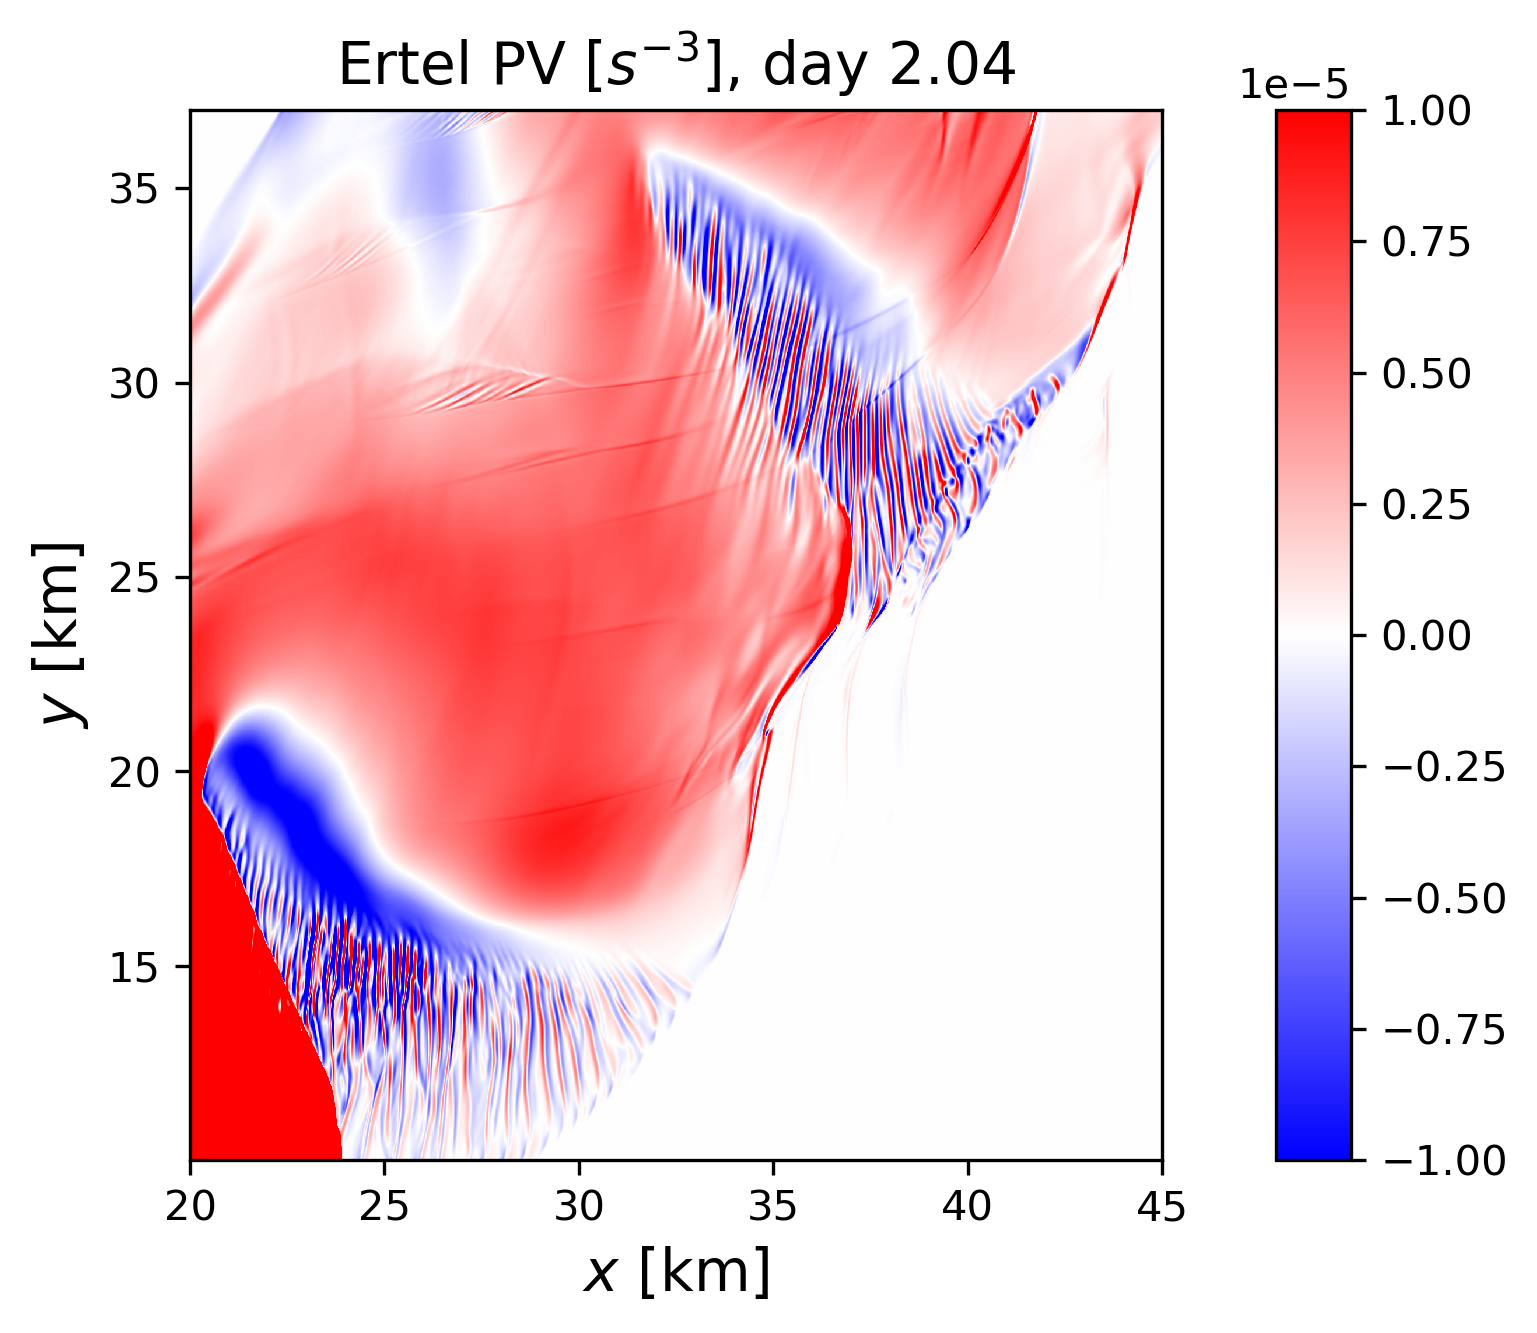

In [43]:

fig = plt.figure(figsize=(5, 5), dpi= 300, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([.9, 0.1, 0.05, 0.7])

 
quad1 = ax1.pcolormesh(EPV.X/1000,EPV.Y/1000,EPV[0,:,:],cmap='bwr',vmin=-1e-5,vmax=1e-5)
#quad1.cmap.set_under('silver')
#ax1.set_xlim(10,50); ax1.set_ylim(0,50)
ax1.set_title('Ertel PV $[s^{-3}]$, day %.2f'%(Time.values/86400), fontsize=14)
#ax1.set_title('Ertel PV $[s^{-3}]$, day %.2f \n 1 meter depth'%(Time.values/86400), fontsize=14)

ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('$x$ [km]',fontsize=14)
ax1.set_ylabel('$y$ [km]',fontsize=14)
ax1.set_aspect('equal');

cb1 = fig.colorbar(quad1,ax2)

#plt.xlabel('(m)', fontsize=14)

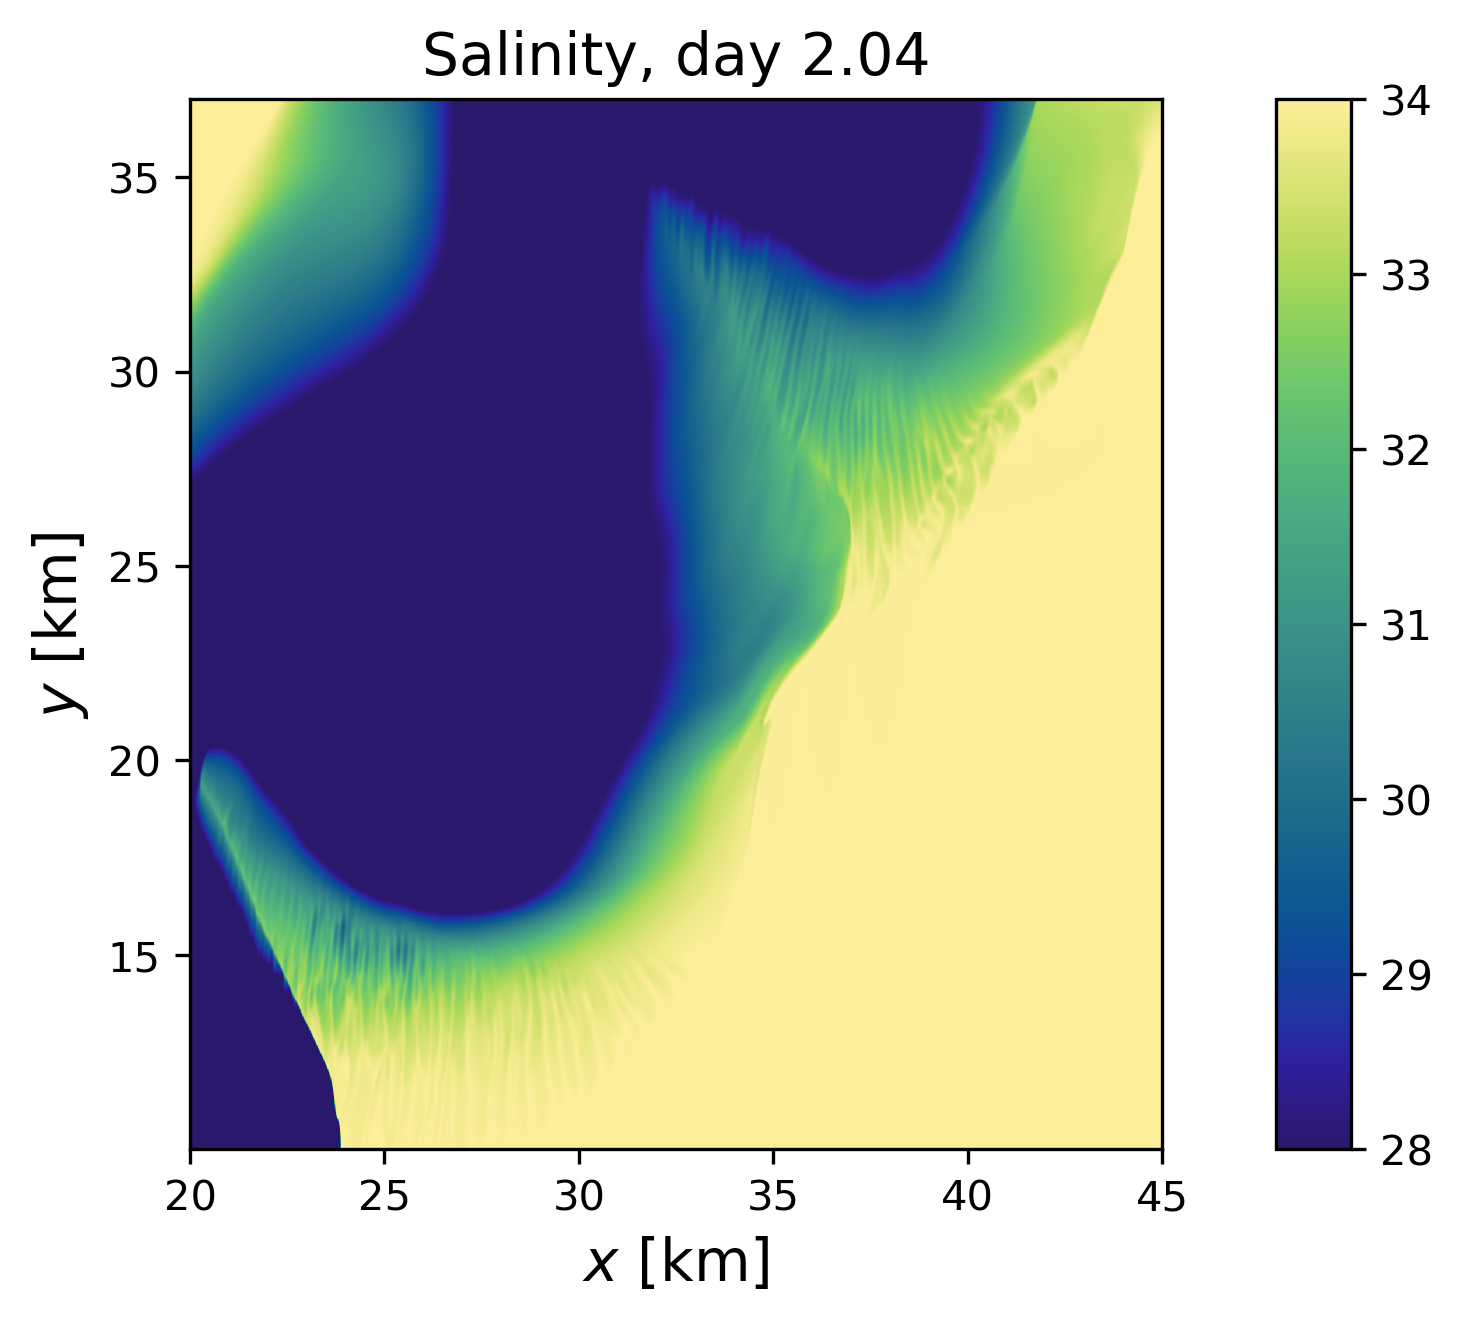

In [41]:

fig = plt.figure(figsize=(5, 5), dpi= 300, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([.9, 0.1, 0.05, 0.7])

 
quad1 = ax1.pcolormesh(EPV.X/1000,EPV.Y/1000,Salt[0,lim3:lim4,lim1:lim2],cmap=cmocean.cm.haline,vmin=28, vmax=34)
#quad1.cmap.set_under('silver')
#ax1.set_xlim(10,50); ax1.set_ylim(0,50);
ax1.set_title('Salinity, day %.2f'%(Time.values/86400), fontsize=14)

#ax1.set_title('Salinity, day %.2f \n 1 meter depth'%(Time.values/86400), fontsize=14)
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('$x$ [km]',fontsize=14)
ax1.set_ylabel('$y$ [km]',fontsize=14)
cb1 = fig.colorbar(quad1,ax2)
ax1.set_aspect('equal');

#plt.xlabel('(psu)', fontsize=14)